1. Data Preparation and Cleaning

Original dataset shape: (1133, 17)

Original columns:
['map', 'day', 'month', 'year', 'date', 'wait_time_s', 'match_time_s', 'team_a_rounds', 'team_b_rounds', 'ping', 'kills', 'assists', 'deaths', 'mvps', 'hs_percent', 'points', 'result']

Dataset shape after dropping columns: (1133, 9)

Remaining columns:
['map', 'ping', 'kills', 'assists', 'deaths', 'mvps', 'hs_percent', 'points', 'result']

Missing values in remaining columns:
map           0
ping          0
kills         0
assists       0
deaths        0
mvps          0
hs_percent    0
points        0
result        0
dtype: int64

Map encoding mapping:
  Mirage -> 0
  Dust II -> 1
  Cache -> 2
  Overpass -> 3
  Cobblestone -> 4
  Inferno -> 5
  Austria -> 6
  Canals -> 7
  Nuke -> 8
  Italy -> 9

Result encoding mapping:
  Win -> 0
  Lost -> 1
  Tie -> 2

Handling outliers in numeric columns...
  Capping 50 outliers in ping
  Capping 25 outliers in kills
  Capping 4 outliers in assists
  Capping 13 outliers in deaths
  Capping 8 ou

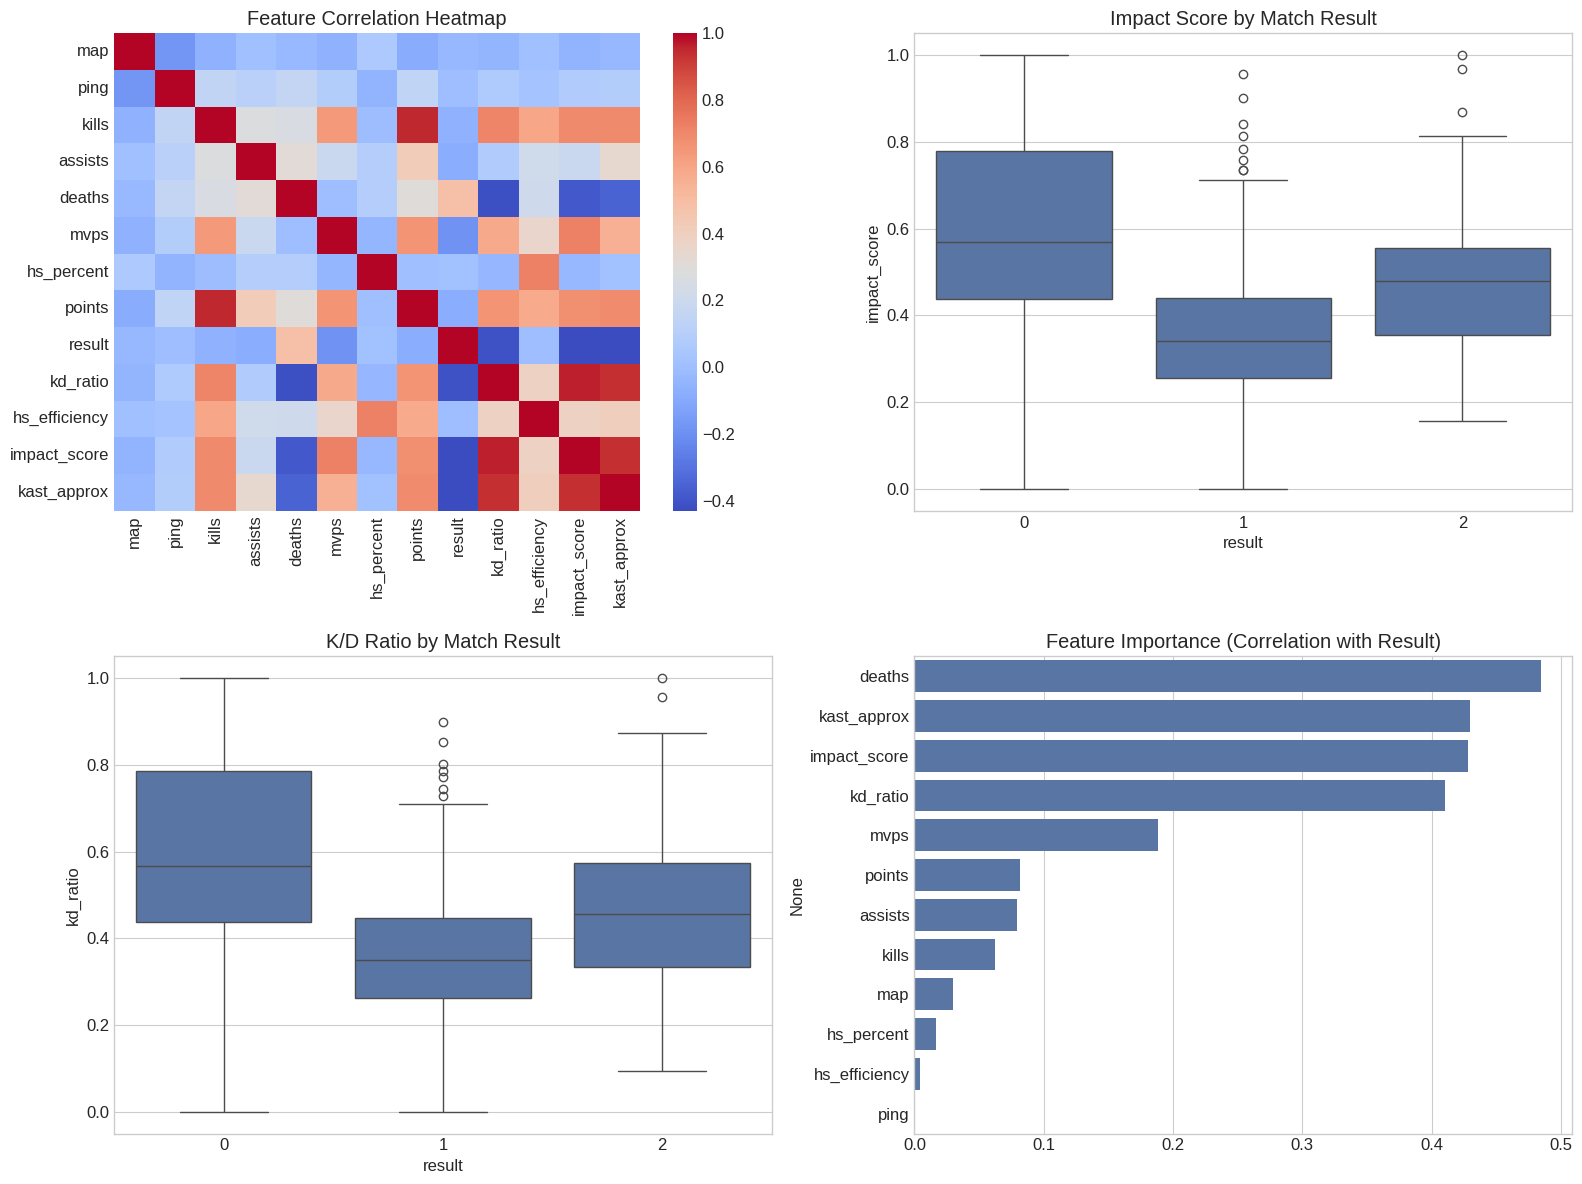

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

def clean_match_prediction_data(file_path):
    """
    Load and clean the match prediction dataset, starting with dropping specified columns

    Parameters:
    file_path (str): Path to the CSV file

    Returns:
    pandas.DataFrame: Cleaned dataset ready for modeling
    """
    # 1. Load the data
    df = pd.read_csv(file_path)

    # 2. Initial data exploration before dropping columns
    print(f"Original dataset shape: {df.shape}")
    print("\nOriginal columns:")
    print(df.columns.tolist())

    # 3. Drop specified columns first as requested
    df = df.drop(['day', 'month', 'year', 'date', 'wait_time_s', 'match_time_s', 'team_a_rounds', 'team_b_rounds'], axis=1)

    print(f"\nDataset shape after dropping columns: {df.shape}")
    print("\nRemaining columns:")
    print(df.columns.tolist())

    # 4. Check for missing values in remaining columns
    missing_values = df.isnull().sum()
    print("\nMissing values in remaining columns:")
    print(missing_values)

    # 5. Handle missing values in remaining columns
    # For numeric columns
    numeric_cols = ['ping', 'kills', 'assists', 'deaths', 'mvps', 'hs_percent', 'points']

    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Filled {col} missing values with median: {median_val}")

    # For categorical columns
    categorical_cols = ['map', 'result']
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
            print(f"Filled {col} missing values with mode: {mode_val}")

    # 6. Encode categorical variables
    # Handle 'map' column
    if df['map'].dtype == 'object':
        # Create mapping dictionary for interpretability
        map_mapping = {map_name: idx for idx, map_name in enumerate(df['map'].unique())}
        print(f"\nMap encoding mapping:")
        for map_name, code in map_mapping.items():
            print(f"  {map_name} -> {code}")

        # Convert to numeric
        df['map'] = df['map'].map(map_mapping)

    # Store original result values before encoding
    if df['result'].dtype == 'object':
        result_categories = df['result'].unique()
        result_mapping = {result: idx for idx, result in enumerate(result_categories)}
        print(f"\nResult encoding mapping:")
        for result, code in result_mapping.items():
            print(f"  {result} -> {code}")

        # Convert to numeric
        df['result'] = df['result'].map(result_mapping)

    # 7. Feature engineering with remaining columns
    # Calculate K/D ratio
    df['kd_ratio'] = df['kills'] / df['deaths'].replace(0, 1)  # Avoid division by zero

    # Calculate headshot efficiency (hs_percent * kills)
    df['hs_efficiency'] = df['hs_percent'] * df['kills'] / 100

    # Calculate impact score (custom metric)
    df['impact_score'] = (df['kills'] + df['assists']*0.5 + df['mvps']*2) / (df['deaths'] + 1)

    # Calculate KAST approximation (simplified version of Kills, Assists, Survived, Traded)
    df['kast_approx'] = (df['kills'] + df['assists']) / (df['deaths'] + df['kills'] + df['assists'])

    # 8. Handle outliers in numeric columns
    print("\nHandling outliers in numeric columns...")

    for col in numeric_cols + ['kd_ratio', 'impact_score', 'hs_efficiency', 'kast_approx']:
        # Calculate IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

        if outliers > 0:
            print(f"  Capping {outliers} outliers in {col}")

            # Cap the outliers
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    # 9. Feature scaling for remaining numeric features
    print("\nScaling numeric features...")

    # Identify columns to scale
    cols_to_scale = numeric_cols + ['kd_ratio', 'impact_score', 'hs_efficiency', 'kast_approx']

    # Apply MinMax scaling
    scaler = MinMaxScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

    # 10. Final check and statistics
    print(f"\nFinal dataset shape: {df.shape}")
    print(f"Columns in final dataset: {df.columns.tolist()}")

    # Correlation with target
    correlation_with_result = df.corr()['result'].sort_values(ascending=False)
    print("\nTop correlations with match result:")
    print(correlation_with_result)

    # 11. Data quality summary
    print("\nSummary statistics for cleaned data:")
    print(df.describe())

    return df

# Function to create visualizations
def visualize_features(df):
    """
    Create informative visualizations for the cleaned data

    Parameters:
    df (pandas.DataFrame): Cleaned dataset
    """
    # Create a figure for multiple plots
    plt.figure(figsize=(16, 12))

    # Plot 1: Correlation heatmap
    plt.subplot(2, 2, 1)
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)
    plt.title('Feature Correlation Heatmap')

    # Plot 2: Distribution of performance metrics by result
    plt.subplot(2, 2, 2)
    sns.boxplot(x='result', y='impact_score', data=df)
    plt.title('Impact Score by Match Result')

    # Plot 3: Distribution of K/D ratio by result
    plt.subplot(2, 2, 3)
    sns.boxplot(x='result', y='kd_ratio', data=df)
    plt.title('K/D Ratio by Match Result')

    # Plot 4: Feature importance (based on correlation with result)
    plt.subplot(2, 2, 4)
    feature_importance = abs(df.corr()['result']).sort_values(ascending=False).drop('result')
    sns.barplot(x=feature_importance.values, y=feature_importance.index)
    plt.title('Feature Importance (Correlation with Result)')
    plt.tight_layout()

    plt.savefig('match_prediction_features.png')
    plt.show()

    return

# Example usage
df = clean_match_prediction_data('/content/csgo.csv')
visualize_features(df)
df.to_csv('cleaned_match_data.csv', index=False)

2. Exploratory Data Analysis (EDA)

DATASET OVERVIEW
Dataset shape: (1133, 13)

Data types:
map                int64
ping             float64
kills            float64
assists          float64
deaths           float64
mvps             float64
hs_percent       float64
points           float64
result             int64
kd_ratio         float64
hs_efficiency    float64
impact_score     float64
kast_approx      float64
dtype: object

Summary statistics:
                count      mean       std  min       25%       50%       75%  \
map            1133.0  1.293910  1.605294  0.0  0.000000  1.000000  1.000000   
ping           1133.0  0.367402  0.247970  0.0  0.168937  0.414169  0.501362   
kills          1133.0  0.505958  0.207933  0.0  0.375000  0.482143  0.625000   
assists        1133.0  0.346131  0.195328  0.0  0.166667  0.333333  0.500000   
deaths         1133.0  0.576665  0.201674  0.0  0.446809  0.617021  0.744681   
mvps           1133.0  0.302883  0.243646  0.0  0.166667  0.333333  0.500000   
hs_percent     1133.0  0

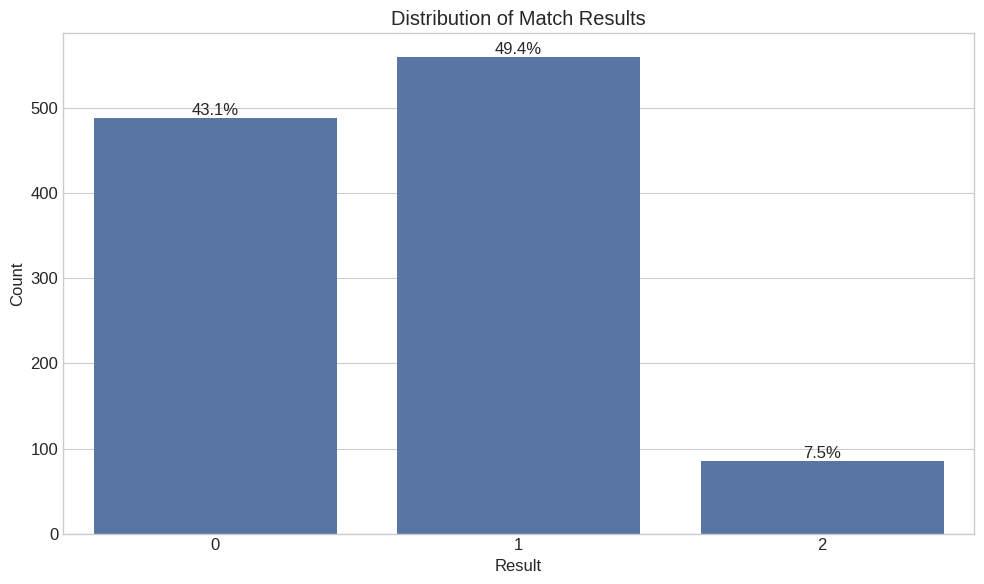


FEATURE DISTRIBUTION ANALYSIS


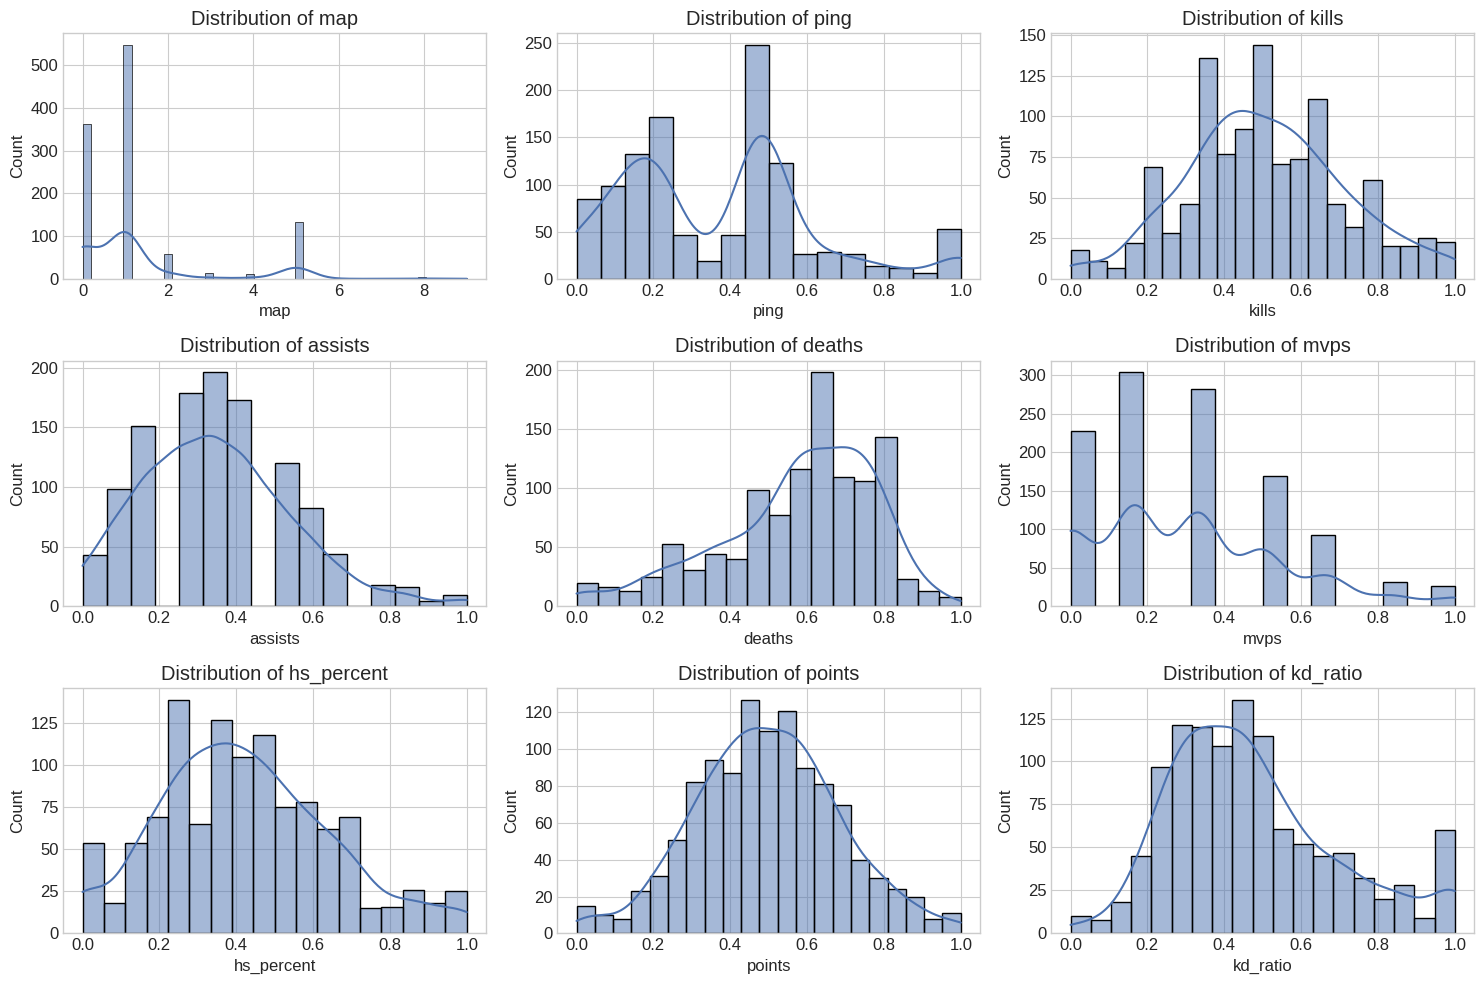


CORRELATION ANALYSIS
Correlation with target variable (result):
result           1.000000
deaths           0.484326
hs_percent       0.016280
ping            -0.000564
hs_efficiency   -0.004430
map             -0.029972
kills           -0.062008
assists         -0.078982
points          -0.081535
mvps            -0.187960
kd_ratio        -0.410068
impact_score    -0.427969
kast_approx     -0.429737
Name: result, dtype: float64


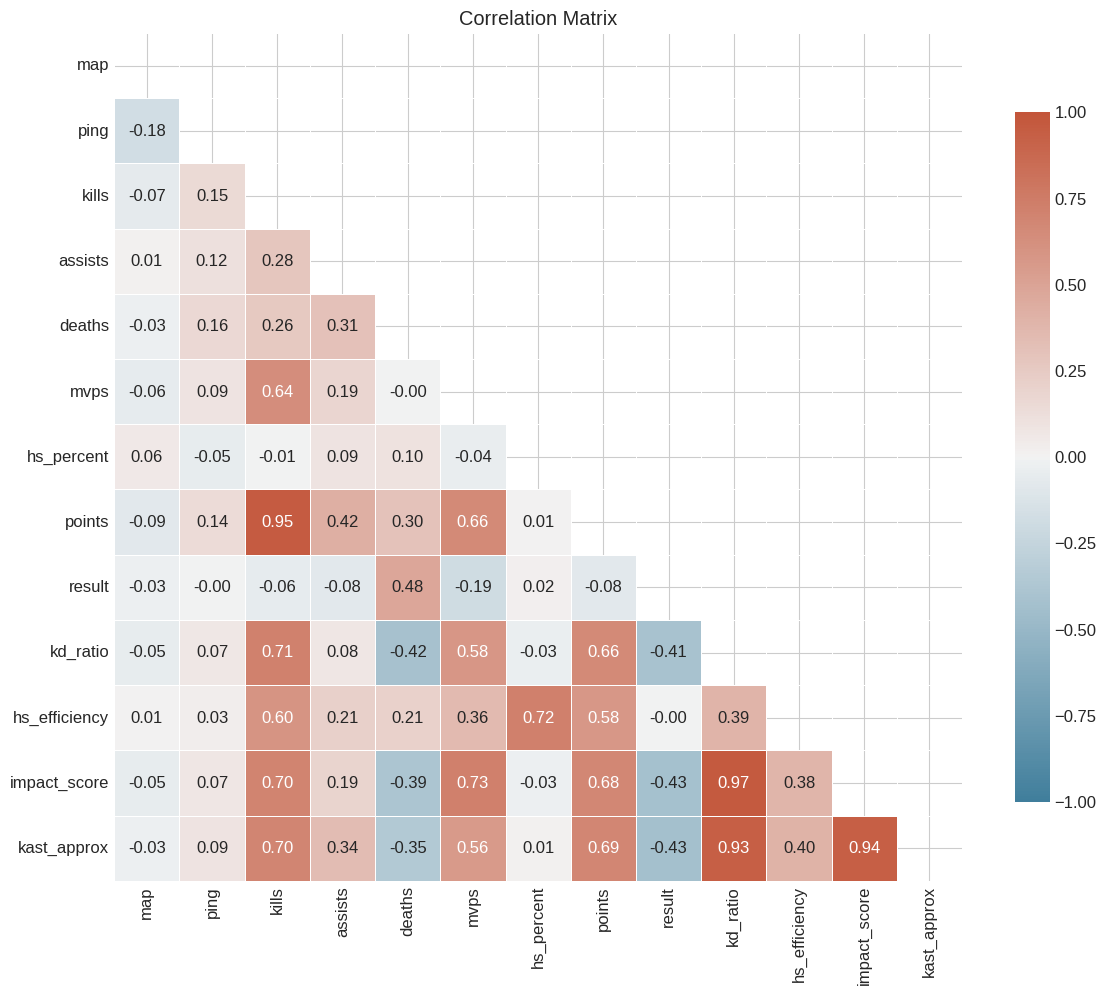


FEATURE RELATIONSHIPS WITH TARGET
Top correlated features with result:
Index(['result', 'deaths', 'hs_percent', 'ping', 'hs_efficiency', 'map'], dtype='object')


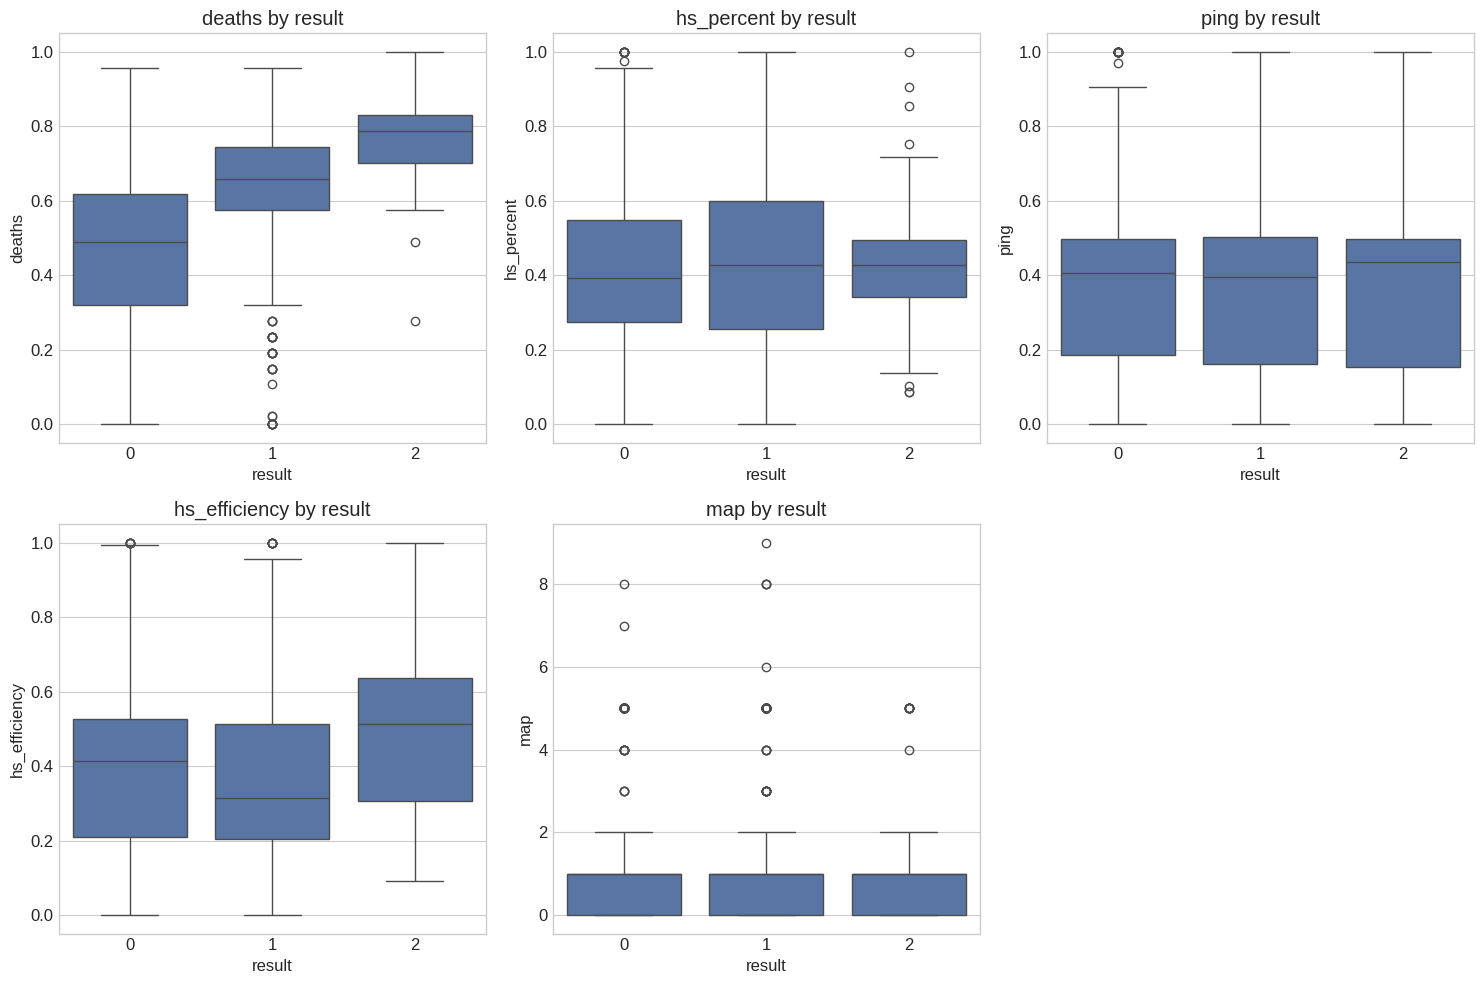


STATISTICAL TESTS

MAP ANALYSIS
Distribution of maps:
map
1    48.278906
0    32.038835
5    11.650485
2     5.207414
3     1.147396
4     1.059135
8     0.353045
6     0.088261
7     0.088261
9     0.088261
Name: proportion, dtype: float64

PERFORMANCE METRICS ANALYSIS


<Figure size 1500x1200 with 0 Axes>

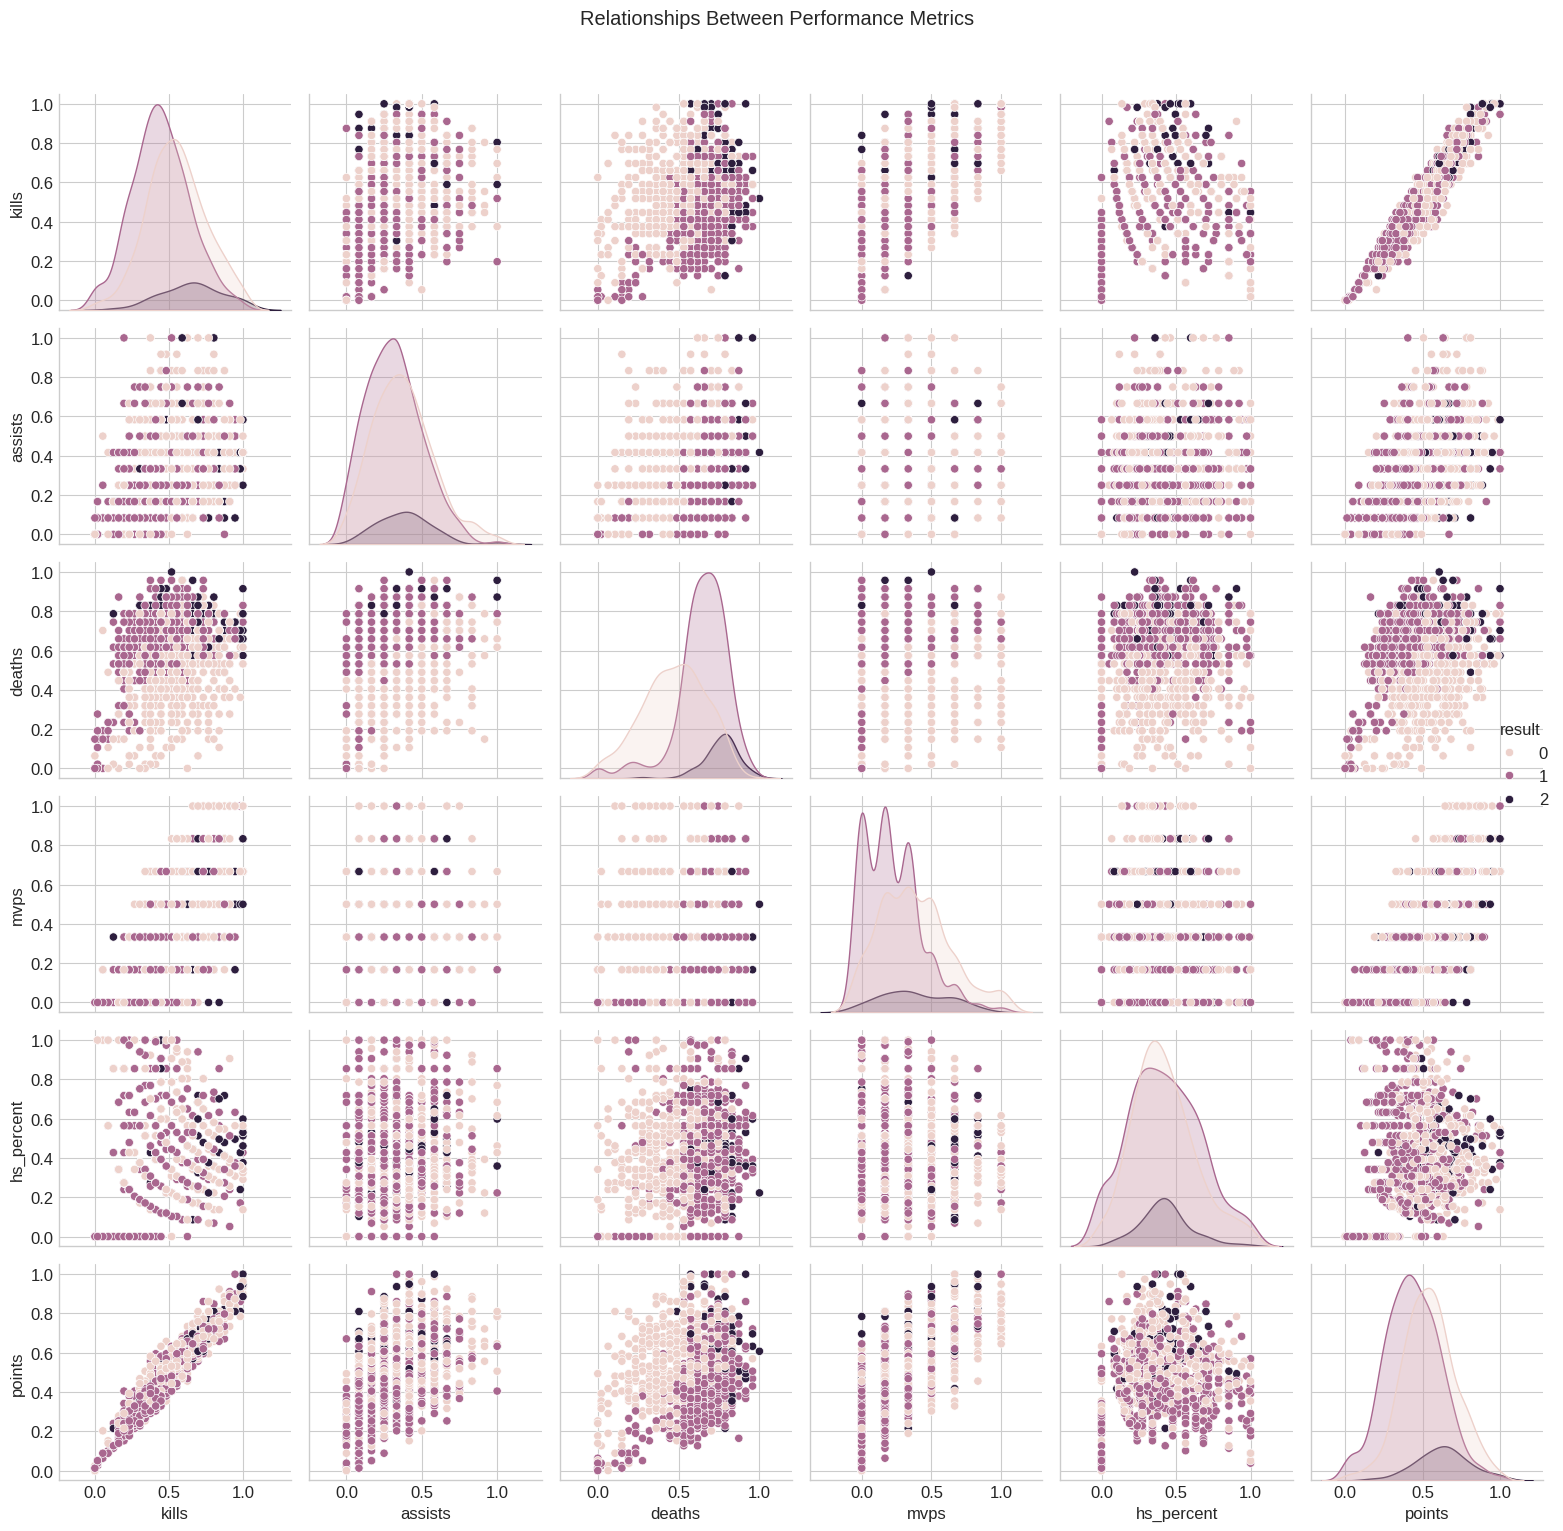

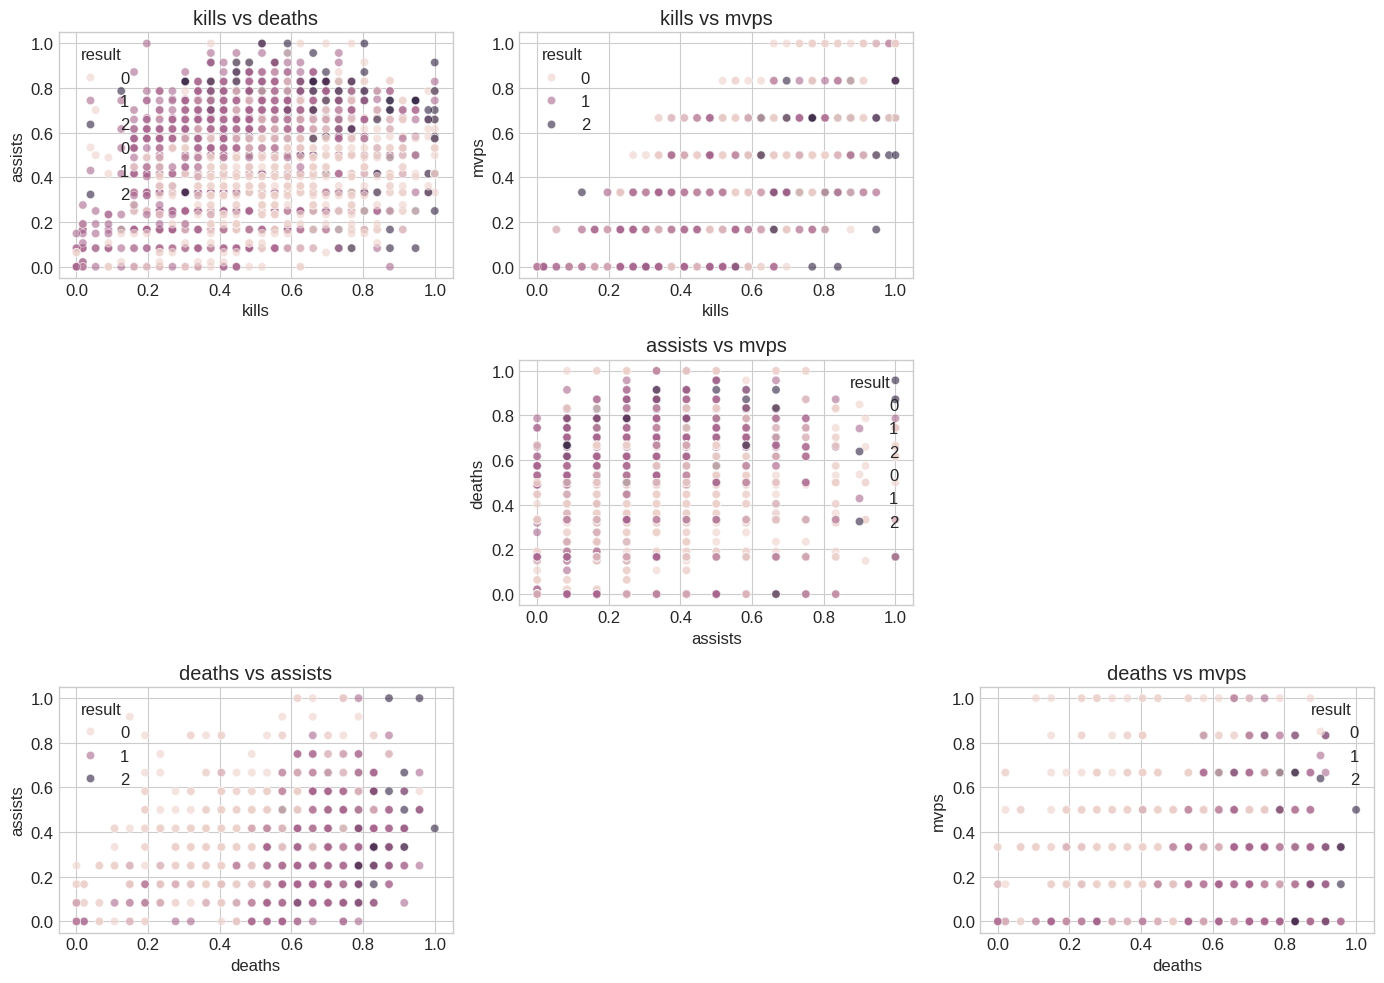


KEY INSIGHTS SUMMARY

Most significant features (correlation with result):
  deaths: 0.484
  kast_approx: 0.430
  impact_score: 0.428
  kd_ratio: 0.410
  mvps: 0.188

Average performance metrics:
  Average kills: 0.51
  Average assists: 0.35
  Average deaths: 0.58
  Average mvps: 0.30
  Average hs_percent: 0.42
  Average points: 0.50


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set styling for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def perform_eda(file_path):
    """
    Comprehensive EDA for match prediction dataset

    Parameters:
    file_path (str): Path to the CSV file
    """
    # Load the preprocessed data
    # Note: We're assuming the data has already gone through cleaning steps
    df = pd.read_csv(file_path)

    # 1. Basic Dataset Overview
    print("="*80)
    print("DATASET OVERVIEW")
    print("="*80)
    print(f"Dataset shape: {df.shape}")
    print("\nData types:")
    print(df.dtypes)
    print("\nSummary statistics:")
    print(df.describe().T)  # Transposed for better readability

    # 2. Target Variable Analysis
    print("\n"+"="*80)
    print("TARGET VARIABLE ANALYSIS")
    print("="*80)

    # Let's examine the distribution of the result (target) variable
    print("Result value counts:")
    result_counts = df['result'].value_counts(normalize=True) * 100
    print(result_counts)

    # Visualize the distribution of results
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='result', data=df)
    plt.title('Distribution of Match Results')
    plt.xlabel('Result')
    plt.ylabel('Count')

    # Add percentage labels
    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('result_distribution.png')
    plt.show()

    # 3. Feature Distribution Analysis
    print("\n"+"="*80)
    print("FEATURE DISTRIBUTION ANALYSIS")
    print("="*80)

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'result']  # Exclude target variable

    # Plot histograms for numeric features
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols[:9], 1):  # Limit to 9 plots
        plt.subplot(3, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()

    plt.savefig('feature_distributions.png')
    plt.show()

    # 4. Correlation Analysis
    print("\n"+"="*80)
    print("CORRELATION ANALYSIS")
    print("="*80)

    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Print correlation with target variable
    print("Correlation with target variable (result):")
    print(corr_matrix['result'].sort_values(ascending=False))

    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .8})

    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()

    # 5. Feature Relationships with Target
    print("\n"+"="*80)
    print("FEATURE RELATIONSHIPS WITH TARGET")
    print("="*80)

    # Identify top correlated features with result
    top_correlated = corr_matrix['result'].sort_values(ascending=False).index[:6]  # Top 5 + result itself
    print("Top correlated features with result:")
    print(top_correlated)

    # Plot boxplots for top features by result
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(top_correlated[1:6], 1):  # Skip 'result' itself
        plt.subplot(2, 3, i)
        sns.boxplot(x='result', y=feature, data=df)
        plt.title(f'{feature} by result')
        plt.tight_layout()

    plt.savefig('features_by_result.png')
    plt.show()

    # 6. Statistical Tests
    print("\n"+"="*80)
    print("STATISTICAL TESTS")
    print("="*80)

    # If result is binary (0/1), we can do t-tests to see if means differ significantly
    if len(df['result'].unique()) == 2:
        result_values = df['result'].unique()
        print("T-tests for difference in means between result groups:")

        for feature in numeric_cols:
            group1 = df[df['result'] == result_values[0]][feature]
            group2 = df[df['result'] == result_values[1]][feature]

            t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
            significance = "Significant" if p_val < 0.05 else "Not significant"

            print(f"{feature}: t-stat={t_stat:.3f}, p-value={p_val:.3g} - {significance}")

    # 7. Map Analysis (if map is categorical)
    if 'map' in df.columns:
        print("\n"+"="*80)
        print("MAP ANALYSIS")
        print("="*80)

        # Map distribution
        map_counts = df['map'].value_counts(normalize=True) * 100
        print("Distribution of maps:")
        print(map_counts)

        # Win rate by map
        if len(df['result'].unique()) == 2:
            print("\nWin rate by map:")
            win_rate_by_map = df.groupby('map')['result'].mean() * 100
            print(win_rate_by_map)

            # Visualize win rate by map
            plt.figure(figsize=(12, 6))
            win_rate_by_map.sort_values().plot(kind='barh')
            plt.title('Win Rate by Map (%)')
            plt.xlabel('Win Rate (%)')
            plt.ylabel('Map')
            plt.tight_layout()
            plt.savefig('win_rate_by_map.png')
            plt.show()

    # 8. Performance Metrics Analysis
    print("\n"+"="*80)
    print("PERFORMANCE METRICS ANALYSIS")
    print("="*80)

    # If we have performance metrics like kills, deaths, etc.
    performance_metrics = [col for col in df.columns if col in ['kills', 'deaths', 'assists', 'mvps', 'hs_percent', 'points']]

    if performance_metrics:
        # Pairplot of performance metrics colored by result
        if len(df['result'].unique()) <= 5:  # Only if reasonable number of result categories
            plt.figure(figsize=(15, 12))
            sns.pairplot(df[performance_metrics + ['result']],
                         hue='result', diag_kind='kde')
            plt.suptitle('Relationships Between Performance Metrics', y=1.02)
            plt.tight_layout()
            plt.savefig('performance_metrics_pairplot.png')
            plt.show()

        # Create scatter plot matrix for key performance metrics
        plt.figure(figsize=(14, 10))
        for i, x_feature in enumerate(performance_metrics[:3], 1):
            for j, y_feature in enumerate(performance_metrics[1:4], 1):
                if x_feature != y_feature:
                  plt.subplot(3, 3, (i-1)*3 + j - (1 if j > i else 0))
                  sns.scatterplot(x=x_feature, y=y_feature, hue='result', data=df, alpha=0.6)
                  plt.title(f'{x_feature} vs {y_feature}')
                  plt.tight_layout()

        plt.savefig('performance_metrics_scatter.png')
        plt.show()

    # 9. Key Insights Summary
    print("\n"+"="*80)
    print("KEY INSIGHTS SUMMARY")
    print("="*80)

    # Calculate win rate (if binary result)
    if len(df['result'].unique()) == 2:
        win_rate = df['result'].mean() * 100
        print(f"Overall win rate: {win_rate:.2f}%")

    # Most significant features (based on correlation)
    print("\nMost significant features (correlation with result):")
    top_features = corr_matrix['result'].abs().sort_values(ascending=False).iloc[1:6]
    for feature, corr in top_features.items():
        print(f"  {feature}: {corr:.3f}")

    # Performance metrics averages
    if performance_metrics:
        print("\nAverage performance metrics:")
        for metric in performance_metrics:
            print(f"  Average {metric}: {df[metric].mean():.2f}")

    return df

# Example usage
df = perform_eda('/content/cleaned_match_data.csv')

3. Advanced Analytics(buiding model)

Loading and preparing data...
Target variable distribution (%):
result
1    49.426302
0    43.071492
2     7.502207
Name: proportion, dtype: float64

Building initial classification models with imbalance handling...
Training set shape: (906, 12)
Testing set shape: (227, 12)

--------------------------------------------------
Training Logistic Regression...
Cross-validation F1-weighted score: 0.6904 ± 0.0281
Test accuracy: 0.6652
Weighted F1 score: 0.6903

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        98
           1       0.80      0.61      0.69       112
           2       0.25      0.76      0.38        17

    accuracy                           0.67       227
   macro avg       0.61      0.70      0.60       227
weighted avg       0.75      0.67      0.69       227



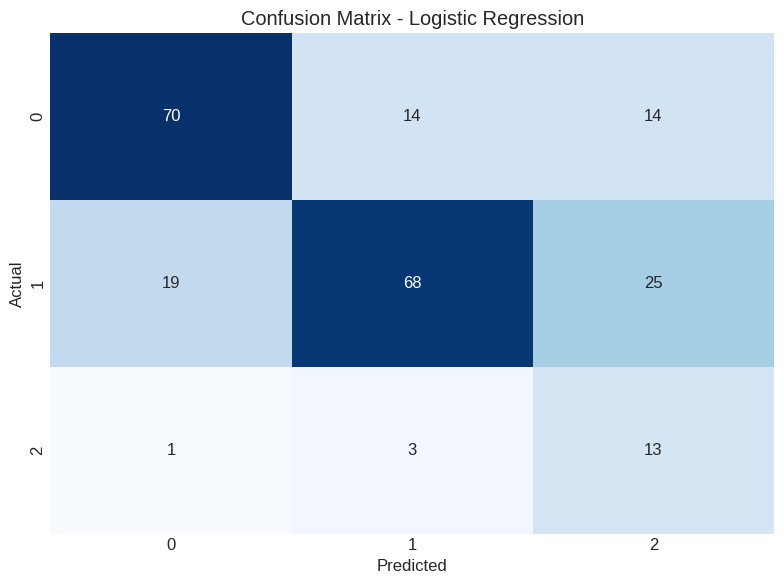


--------------------------------------------------
Training Random Forest...
Cross-validation F1-weighted score: 0.7003 ± 0.0500
Test accuracy: 0.7093
Weighted F1 score: 0.7135

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.76        98
           1       0.71      0.76      0.74       112
           2       0.29      0.35      0.32        17

    accuracy                           0.71       227
   macro avg       0.60      0.61      0.60       227
weighted avg       0.72      0.71      0.71       227



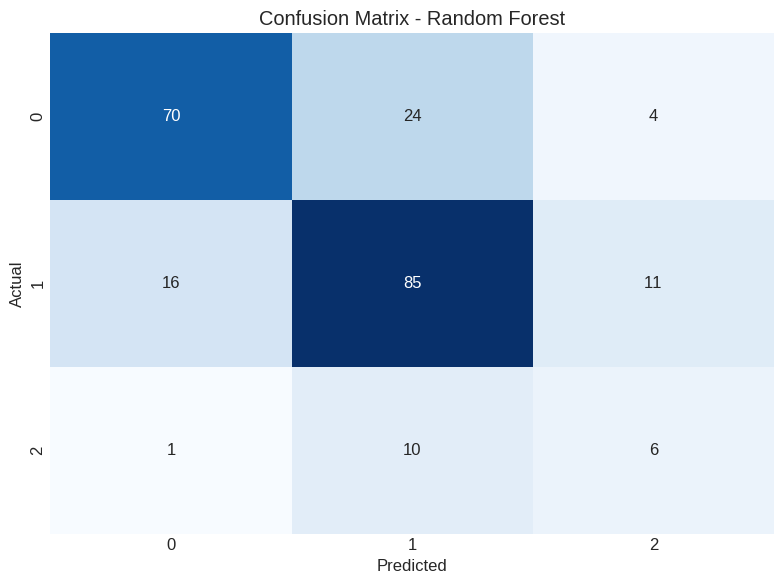


--------------------------------------------------
Training Gradient Boosting...
Cross-validation F1-weighted score: 0.7093 ± 0.0412
Test accuracy: 0.7048
Weighted F1 score: 0.7060

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        98
           1       0.71      0.76      0.74       112
           2       0.28      0.29      0.29        17

    accuracy                           0.70       227
   macro avg       0.59      0.59      0.59       227
weighted avg       0.71      0.70      0.71       227



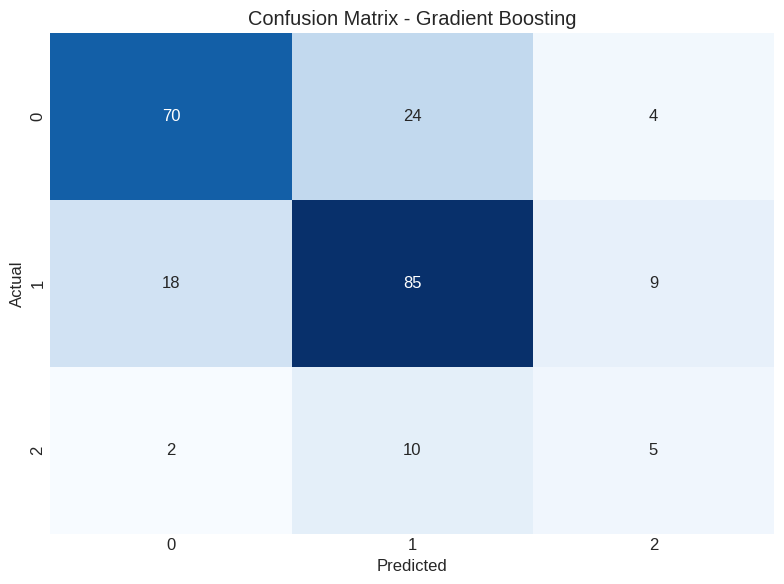


--------------------------------------------------
Training XGBoost...
Cross-validation F1-weighted score: 0.7044 ± 0.0376
Test accuracy: 0.7004
Weighted F1 score: 0.6947

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        98
           1       0.70      0.75      0.72       112
           2       0.36      0.24      0.29        17

    accuracy                           0.70       227
   macro avg       0.60      0.57      0.58       227
weighted avg       0.69      0.70      0.69       227



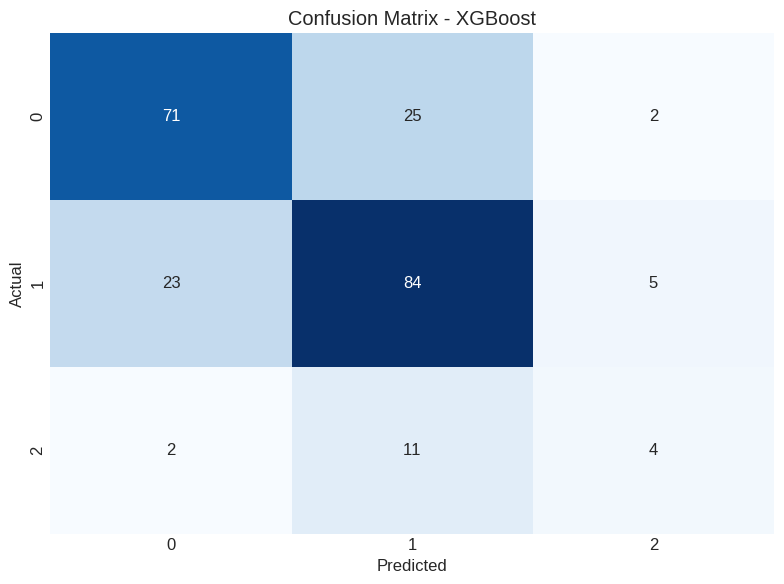


--------------------------------------------------
Training SVM...
Cross-validation F1-weighted score: 0.6826 ± 0.0341
Test accuracy: 0.6652
Weighted F1 score: 0.6904

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.77        98
           1       0.73      0.65      0.69       112
           2       0.19      0.47      0.27        17

    accuracy                           0.67       227
   macro avg       0.58      0.61      0.57       227
weighted avg       0.73      0.67      0.69       227



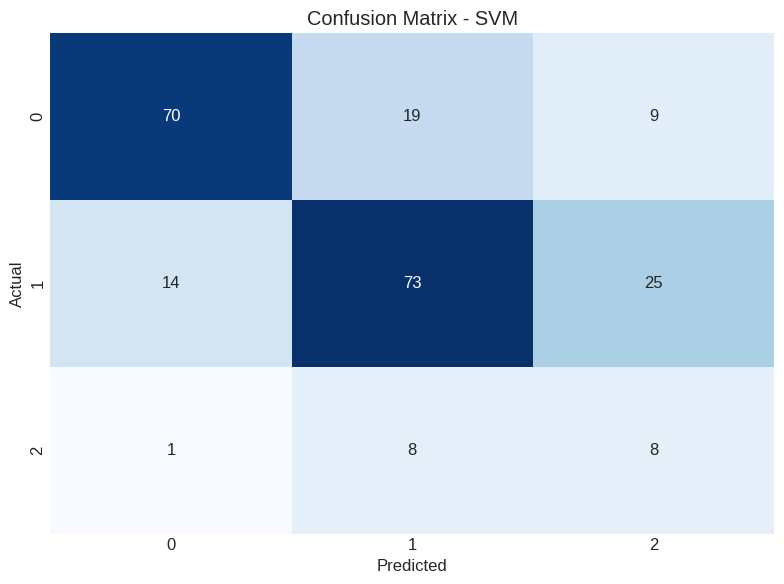


--------------------------------------------------
Training Neural Network...
Cross-validation F1-weighted score: 0.6861 ± 0.0445
Test accuracy: 0.6652
Weighted F1 score: 0.6766

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        98
           1       0.68      0.68      0.68       112
           2       0.21      0.35      0.27        17

    accuracy                           0.67       227
   macro avg       0.56      0.58      0.56       227
weighted avg       0.69      0.67      0.68       227



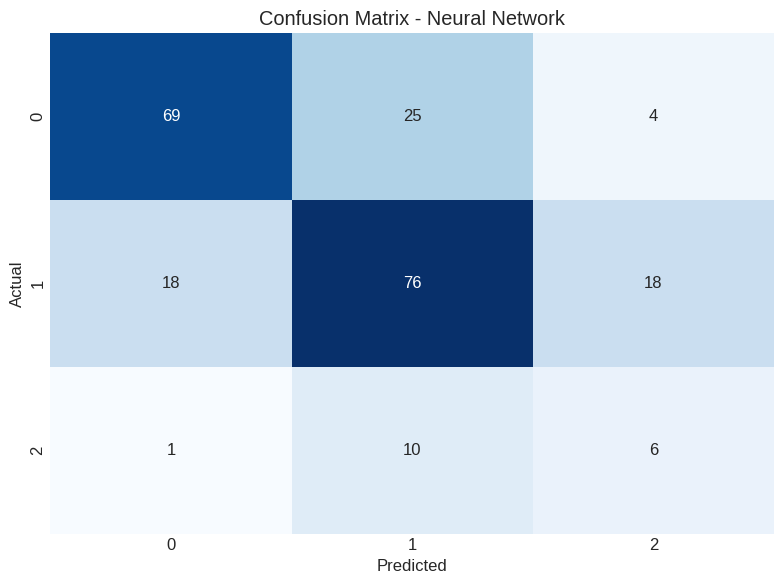


Best performing model: Random Forest
Accuracy: 0.7093

--------------------------------------------------
Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Best cross-validation F1-weighted score: 0.7162


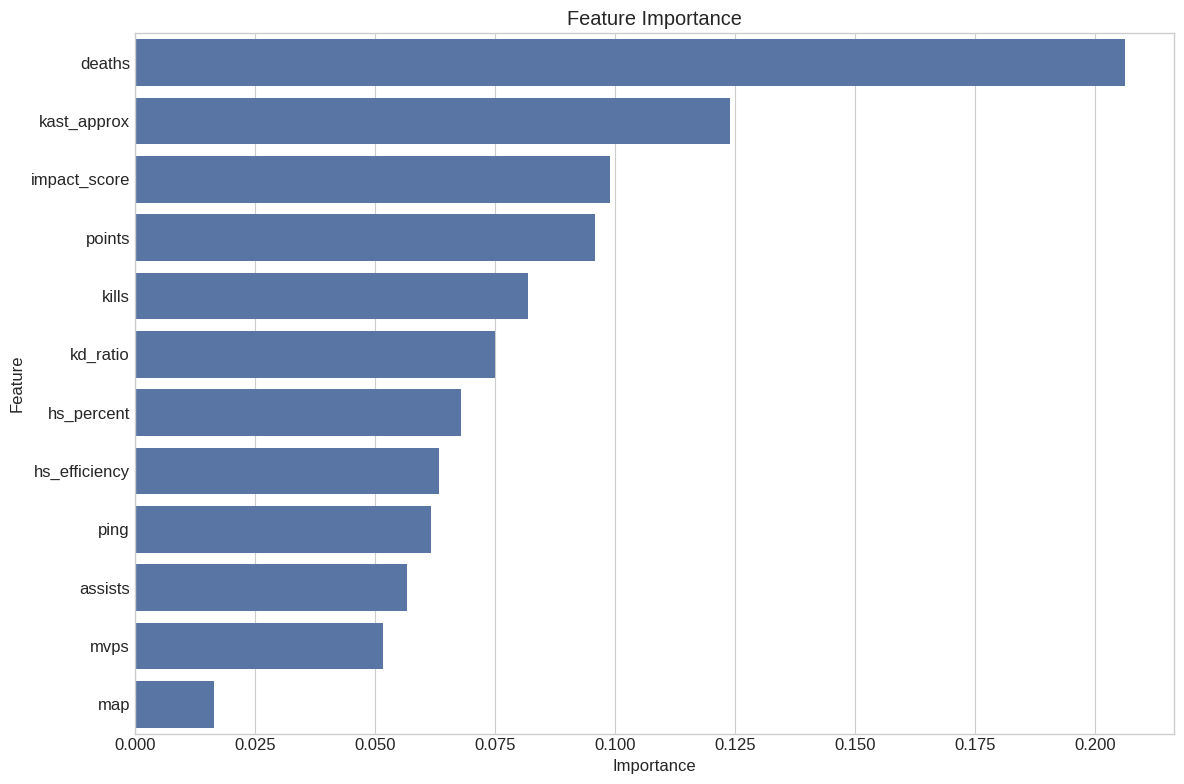


Top 5 most important features:
         Feature  Importance
4         deaths    0.206174
11   kast_approx    0.124057
10  impact_score    0.098951
7         points    0.095929
2          kills    0.081952

--------------------------------------------------
Final evaluation of Random Forest...
Test accuracy: 0.6872

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        98
           1       0.70      0.72      0.71       112
           2       0.24      0.29      0.26        17

    accuracy                           0.69       227
   macro avg       0.57      0.58      0.57       227
weighted avg       0.70      0.69      0.69       227



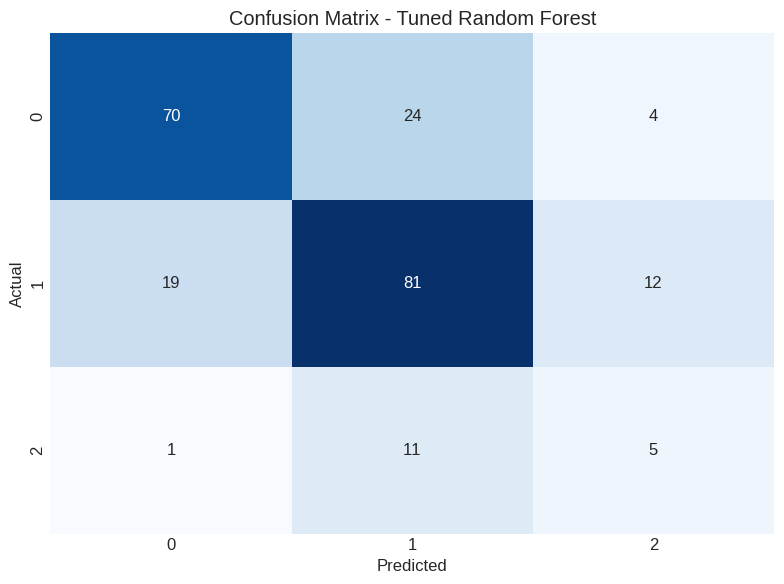


Final model accuracy: 0.6872

Best model saved as: best_model_random_forest.joblib

Advanced analytics completed!

Advanced analytics completed!


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE  # Added for imbalance handling
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline compatible with SMOTE
from joblib import dump, load

import warnings

warnings.filterwarnings('ignore')


def load_and_prepare_data(file_path):
    """
    Load and prepare data for modeling
    """
    # Load cleaned data
    df = pd.read_csv(file_path)

    # Separate features and target
    X = df.drop('result', axis=1)
    y = df['result']

    # Print class distribution to identify imbalance
    print("Target variable distribution (%):")
    distribution = y.value_counts(normalize=True) * 100
    print(distribution)
    if distribution.min() < 15:
        print("Warning: Detected potential class imbalance (minority class < 15%). SMOTE will be applied.")

    return X, y


def build_classification_models(X, y):
    """
    Build and evaluate multiple classification models with imbalance handling using SMOTE
    """
    # Split data into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial'),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
    }

    # Dictionary to store model performance
    model_results = {}

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n{'-' * 50}")
        print(f"Training {name}...")

        # Create a pipeline with SMOTE for imbalance handling
        pipeline = ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
            ('smote', SMOTE(random_state=42)),  # Handle class imbalance by oversampling minority classes
            ('scaler', StandardScaler()),  # Scale features
            ('model', model)  # Classifier
        ])

        # Cross-validation with F1-weighted scoring to account for imbalance
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1_weighted')
        print(f"Cross-validation F1-weighted score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        # Train the model
        pipeline.fit(X_train, y_train)

        # Predictions
        y_pred = pipeline.predict(X_test)

        # Performance metrics
        accuracy = accuracy_score(y_test, y_pred)

        # For multi-class (Win, Lose, Tie)
        if len(np.unique(y)) > 2:
            y_pred_proba = pipeline.predict_proba(X_test)
            f1 = f1_score(y_test, y_pred, average='weighted')

            print(f"Test accuracy: {accuracy:.4f}")
            print(f"Weighted F1 score: {f1:.4f}")

            # Store results
            model_results[name] = {
                'cv_f1_weighted': cv_scores.mean(),
                'test_accuracy': accuracy,
                'f1_score': f1,
                'model': pipeline,
                'predictions': y_pred
            }
        else:
            # Binary classification (unlikely based on your context, but kept for completeness)
            roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
            f1 = f1_score(y_test, y_pred)

            print(f"Test accuracy: {accuracy:.4f}")
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"F1 score: {f1:.4f}")

            model_results[name] = {
                'cv_f1_weighted': cv_scores.mean(),
                'test_accuracy': accuracy,
                'roc_auc': roc_auc,
                'f1_score': f1,
                'model': pipeline,
                'predictions': y_pred
            }

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion matrix as heatmap
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png')
        plt.show()
        plt.close()

    return model_results


def hyperparameter_tuning(X_train, y_train, best_model_name, best_model_pipeline):
    """
    Perform hyperparameter tuning on the best model
    """
    print(f"\n{'-' * 50}")
    print(f"Hyperparameter tuning for {best_model_name}...")

    # Define parameter grid based on the best model
    if best_model_name == 'Logistic Regression':
        param_grid = {
            'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'model__solver': ['lbfgs', 'saga'],
            'model__penalty': ['l2', 'none']
        }
    elif best_model_name == 'Random Forest':
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    elif best_model_name == 'Gradient Boosting':
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.8, 1.0]
        }
    elif best_model_name == 'XGBoost':
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        }
    elif best_model_name == 'SVM':
        param_grid = {
            'model__C': [0.1, 1, 10, 100],
            'model__gamma': ['scale', 'auto', 0.1, 0.01],
            'model__kernel': ['rbf', 'poly', 'sigmoid']
        }
    else:  # Neural Network
        param_grid = {
            'model__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'model__activation': ['relu', 'tanh'],
            'model__alpha': [0.0001, 0.001, 0.01],
            'model__learning_rate': ['constant', 'adaptive']
        }

    # Grid search with cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        best_model_pipeline,
        param_grid,
        cv=skf,
        scoring='f1_weighted',  # Changed to f1_weighted for imbalance
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1-weighted score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_


def feature_importance_analysis(X, best_model):
    """
    Analyze feature importance from the best model
    """
    model = best_model.named_steps['model']
    feature_names = X.columns

    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_).mean(axis=0) if model.coef_.ndim > 1 else np.abs(model.coef_)
    else:
        print("Feature importance not available for this model type")
        return

    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    return feature_importance


def evaluate_best_model(X_test, y_test, best_model, model_name):
    """
    Final evaluation of the best model
    """
    print(f"\n{'-' * 50}")
    print(f"Final evaluation of {model_name}...")

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix - Tuned {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tuned_{model_name.replace(" ", "_").lower()}.png')
    plt.show()
    plt.close()

    return accuracy, y_pred


def run_advanced_analytics(file_path):
    """
    End-to-end advanced analytics pipeline with imbalance handling
    """
    print("Loading and preparing data...")
    X, y = load_and_prepare_data(file_path)

    # Split data for final evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\nBuilding initial classification models with imbalance handling...")
    model_results = build_classification_models(X, y)

    # Find the best performing model
    best_model_name = max(model_results, key=lambda k: model_results[k]['test_accuracy'])
    best_model = model_results[best_model_name]['model']

    print(f"\nBest performing model: {best_model_name}")
    print(f"Accuracy: {model_results[best_model_name]['test_accuracy']:.4f}")

    # Hyperparameter tuning
    tuned_model = hyperparameter_tuning(X_train, y_train, best_model_name, best_model)

    # Feature importance analysis
    if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Logistic Regression']:
        feature_importance = feature_importance_analysis(X, tuned_model)
        print("\nTop 5 most important features:")
        print(feature_importance.head(5))

    # Final evaluation
    final_accuracy, final_predictions = evaluate_best_model(X_test, y_test, tuned_model, best_model_name)

    print(f"\nFinal model accuracy: {final_accuracy:.4f}")

    # Save the trained model
    model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}.joblib"
    dump(tuned_model, model_filename)
    print(f"\nBest model saved as: {model_filename}")

    print("\nAdvanced analytics completed!")

    print("\nAdvanced analytics completed!")

    return tuned_model


# Example usage
if __name__ == "__main__":
    best_model = run_advanced_analytics('cleaned_match_data.csv')

4.DEMO


In [16]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler

def load_model(model_path):
    """
    Load a trained model from disk

    Parameters:
    model_path (str): Path to the saved model file

    Returns:
    object: Loaded model
    """
    print(f"Loading model from {model_path}...")
    model = joblib.load(model_path)
    return model

def prepare_match_data(match_data):
    """
    Prepare a single match's data for prediction

    Parameters:
    match_data (dict): Dictionary containing match statistics

    Returns:
    pandas.DataFrame: DataFrame ready for prediction
    """
    # Convert match data to DataFrame
    df = pd.DataFrame([match_data])

    # Ensure map is encoded the same way as in training
    map_mapping = {
        'Mirage': 0,
        'Dust2': 1,
        'Inferno': 2,
        'Nuke': 3,
        'Overpass': 4,
        'Train': 5,
        'Vertigo': 6,
        'Cache': 7,
        'Cobblestone': 8,
        'Ancient': 9
    }

    if 'map' in df.columns and df['map'].dtype == 'object':
        df['map'] = df['map'].map(map_mapping)

    # Feature engineering (same as in training)
    # Calculate K/D ratio
    df['kd_ratio'] = df['kills'] / df['deaths'].replace(0, 1)  # Avoid division by zero

    # Calculate headshot efficiency
    df['hs_efficiency'] = df['hs_percent'] * df['kills'] / 100

    # Calculate impact score
    df['impact_score'] = (df['kills'] + df['assists'] * 0.5 + df['mvps'] * 2) / (df['deaths'] + 1)

    # Calculate KAST approximation
    df['kast_approx'] = (df['kills'] + df['assists']) / (df['deaths'] + df['kills'] + df['assists'])

    print("Match data prepared successfully!")
    return df

def predict_match_result(model, match_df):
    """
    Predict the result of a match

    Parameters:
    model: Trained model
    match_df (pandas.DataFrame): DataFrame with match statistics

    Returns:
    tuple: Predicted result and probability
    """
    # Make prediction
    if 'result' in match_df.columns:
        match_df = match_df.drop('result', axis=1)

    prediction = model.predict(match_df)
    probabilities = model.predict_proba(match_df)

    result_mapping = {0: "Loss", 1: "Win"}
    predicted_result = result_mapping.get(prediction[0], f"Class {prediction[0]}")

    print(f"Prediction complete!")
    return predicted_result, probabilities

def explain_prediction(match_data, predicted_result, probabilities):
    """
    Explain the prediction in human-readable terms

    Parameters:
    match_data (dict): Original match data
    predicted_result (str): Predicted match result
    probabilities (array): Prediction probabilities

    Returns:
    str: Explanation of prediction
    """
    # Generate explanation based on key stats and model probabilities
    max_prob = max(probabilities[0]) * 100

    explanation = f"Prediction: {predicted_result} (Confidence: {max_prob:.1f}%)\n\n"
    explanation += "Key performance factors:\n"

    # Add key statistics that influenced the prediction
    kd_ratio = match_data['kills'] / max(1, match_data['deaths'])
    explanation += f"- K/D Ratio: {kd_ratio:.2f}\n"
    explanation += f"- Kills: {match_data['kills']}\n"
    explanation += f"- Deaths: {match_data['deaths']}\n"
    explanation += f"- Assists: {match_data['assists']}\n"
    explanation += f"- MVPs: {match_data['mvps']}\n"
    explanation += f"- Headshot %: {match_data['hs_percent']}%\n"
    explanation += f"- Points: {match_data['points']}\n"
    explanation += f"- Map: {match_data['map']}"

    # Add interpretation
    explanation += "\n\nInterpretation:\n"
    if predicted_result == "Win":
        if max_prob > 75:
            explanation += "Your performance stats strongly indicate a victory."
        else:
            explanation += "Your performance suggests a win, but it could be a close match."
    else:
        if max_prob > 75:
            explanation += "Your performance stats strongly indicate a loss."
        else:
            explanation += "Your performance suggests a loss, but you might have a chance to turn it around."

    return explanation

def main():
    """
    Main function to demonstrate the prediction pipeline
    """
    print("\n===== CS:GO Match Result Predictor =====\n")

    # Try to load the model - if not found, provide instructions
    try:
        model = load_model("/content/best_model_random_forest.joblib")  # Adjust filename as needed
    except FileNotFoundError:
        print("Model file not found! You need to run the training script first.")
        print("Example model filenames could be: best_model_random_forest.joblib, best_model_xgboost.joblib, etc.")
        return

    # Example match data (modify this with your own match data)
    example_match = {
        'map': 'Mirage',
        'ping': 45,
        'kills': 20,
        'assists': 5,
        'deaths': 15,
        'mvps': 3,
        'hs_percent': 40.0,
        'points': 60
    }

    # Option to use demo data or input own data
    print("1. Use example match data")
    print("2. Input your own match data")
    choice = input("Select an option (1/2): ")

    if choice == '2':
        maps = ['Mirage', 'Dust2', 'Inferno', 'Nuke', 'Overpass', 'Train', 'Vertigo', 'Cache', 'Cobblestone', 'Ancient']
        print("\nAvailable maps:", ', '.join(maps))

        match_data = {}
        match_data['map'] = input("Map name: ")
        match_data['ping'] = int(input("Ping: "))
        match_data['kills'] = int(input("Kills: "))
        match_data['assists'] = int(input("Assists: "))
        match_data['deaths'] = int(input("Deaths: "))
        match_data['mvps'] = int(input("MVPs: "))
        match_data['hs_percent'] = float(input("Headshot percentage: "))
        match_data['points'] = int(input("Points: "))
    else:
        match_data = example_match
        print("\nUsing example match data:")
        for key, value in match_data.items():
            print(f"- {key}: {value}")

    # Prepare the data
    print("\nPreparing match data...")
    match_df = prepare_match_data(match_data)

    # Make prediction
    print("\nPredicting match result...")
    result, probs = predict_match_result(model, match_df)

    # Explain prediction
    explanation = explain_prediction(match_data, result, probs)

    # Display results
    print("\n===== Prediction Results =====")
    print(explanation)
    print("\n==============================")

if __name__ == "__main__":
    main()


===== CS:GO Match Result Predictor =====

Loading model from /content/best_model_random_forest.joblib...
1. Use example match data
2. Input your own match data
Select an option (1/2): 1

Using example match data:
- map: Mirage
- ping: 45
- kills: 20
- assists: 5
- deaths: 15
- mvps: 3
- hs_percent: 40.0
- points: 60

Preparing match data...
Match data prepared successfully!

Predicting match result...
Prediction complete!

===== Prediction Results =====
Prediction: Win (Confidence: 42.5%)

Key performance factors:
- K/D Ratio: 1.33
- Kills: 20
- Deaths: 15
- Assists: 5
- MVPs: 3
- Headshot %: 40.0%
- Points: 60
- Map: Mirage

Interpretation:
Your performance suggests a win, but it could be a close match.

